# Implement a ResNet18-like architecture for the CIFAR10 dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 100
batch_size = 128

CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
transform = transforms.Compose(
    [transforms.RandomCrop (32, padding = 4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


dataset_train = torchvision.datasets.CIFAR10('.', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

dataset_test = torchvision.datasets.CIFAR10('.', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualization_dataset(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    plt.figure(figsize = (10,10))

    imshow(torchvision.utils.make_grid(images))

    print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(batch_size)))


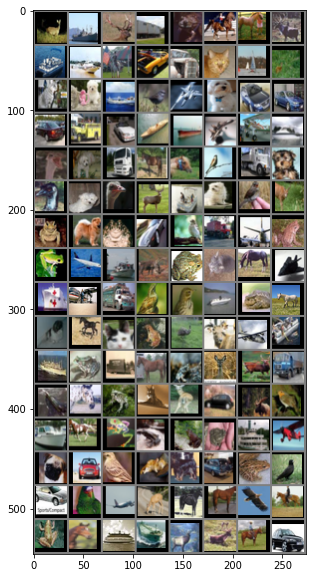

deer  ship  deer  truck frog  horse horse deer  ship  ship  horse car   truck cat   ship  deer  cat   dog   ship  bird  plane dog   car   car   car   truck car   ship  ship  plane plane ship  bird  dog   truck horse horse bird  truck dog   bird  dog   bird  deer  ship  dog   bird  deer  frog  dog   frog  car   bird  truck plane frog  frog  plane ship  deer  frog  cat   horse plane ship  plane truck bird  bird  ship  frog  horse dog   horse cat   frog  bird  deer  plane ship  ship  frog  truck horse frog  deer  deer  truck plane horse frog  cat   deer  car   deer  bird  ship  horse frog  frog  frog  frog  ship  plane dog   car   bird  cat   dog   car   frog  bird  car   bird  plane deer  horse horse bird  horse frog  horse ship  ship  deer  deer  horse car  


In [ ]:
visualization_dataset(trainloader)
#visualization_dataset(testloader)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
      x = nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))
      return x

class ResNet18(nn.Module):
    def __init__(self, block, num_block, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def get_model_ResNet18():
  return ResNet18(BasicBlock, [2, 2, 2, 2])

In [ ]:
def train_model(model, trainloader, optim, loss_func, realization):
  model.to(device)
  loss_for_draw_train = []
  loss_for_draw_test = []
  for epoch in range(n_epochs):
      loss_average_epoch = 0
      for i, batch in enumerate(trainloader):
          inputs, labels = batch
          optim.zero_grad()

          predict = model(inputs.to(device))
          loss = loss_func(predict, labels.to(device))
          loss.backward()
          optim.step()
          loss_average_epoch += loss
          if i % 100 == 0:
              print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
      loss_for_draw_train.append(float(loss_average_epoch/i))

      #test model
      for i, batch in enumerate(testloader):
          inputs, labels = batch

          model.eval()
          loss_test = 0
          with torch.no_grad():
              predict = model(inputs.to(device))
              loss_test += loss_func(predict, labels.to(device))

      model.train()
      loss_for_draw_test.append(float(loss_test / i))
      print('test loss:', loss_test / i)
      #save every epoch

      torch.save(model.state_dict(), f'./chkpt_cv1_conv_{epoch}_{realization}.pth')


  plt.plot(loss_for_draw_train, 'r')
  plt.plot(loss_for_draw_test, 'b')
  plt.legend(['Train loss', 'Test loss'])
  plt.title("Learning curve")
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

  return model

In [ ]:
def test_model(model, testloader):
  correct, total = 0, 0
  with torch.no_grad():
    for i, batch in enumerate(testloader, 0):

      inputs, targets = batch
      outputs = model(inputs.to(device))

      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += (predicted == targets.to(device)).sum().item()

    print('Accuracy %d %%' % (100.0 * (correct / total)))
    return (100.0 * (correct / total))

In [ ]:
import pandas as pd
results =  pd.DataFrame(index=['accuracy'])

## Training a model with its own implementation.

epoch: 0, step: 0, loss: 2.3370707035064697
epoch: 0, step: 100, loss: 2.1046319007873535
epoch: 0, step: 200, loss: 1.69474196434021
epoch: 0, step: 300, loss: 1.6647934913635254
test loss: tensor(0.0202, device='cuda:0')
epoch: 1, step: 0, loss: 1.625318169593811
epoch: 1, step: 100, loss: 1.3905677795410156
epoch: 1, step: 200, loss: 1.2090741395950317
epoch: 1, step: 300, loss: 1.241805076599121
test loss: tensor(0.0187, device='cuda:0')
epoch: 2, step: 0, loss: 1.3549339771270752
epoch: 2, step: 100, loss: 1.0101280212402344
epoch: 2, step: 200, loss: 0.9500862956047058
epoch: 2, step: 300, loss: 1.0193147659301758
test loss: tensor(0.0092, device='cuda:0')
epoch: 3, step: 0, loss: 0.9509046673774719
epoch: 3, step: 100, loss: 0.9678212404251099
epoch: 3, step: 200, loss: 0.8716987371444702
epoch: 3, step: 300, loss: 0.6999285221099854
test loss: tensor(0.0116, device='cuda:0')
epoch: 4, step: 0, loss: 0.6394584774971008
epoch: 4, step: 100, loss: 0.8436687588691711
epoch: 4, step

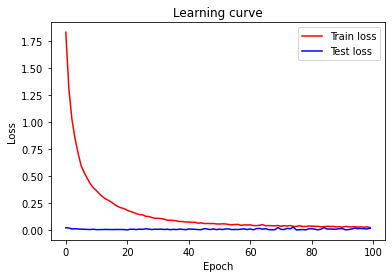

Accuracy 90 %


In [ ]:
model = get_model_ResNet18()
optim = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_func = nn.CrossEntropyLoss()

trained_model = train_model(model,trainloader, optim, loss_func, 'Own realization')
results['Own realization'] = test_model(trained_model, testloader)

## Training a model derived from the Transfer learning approach.

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0, step: 0, loss: 2.5036633014678955
epoch: 0, step: 100, loss: 2.054908275604248
epoch: 0, step: 200, loss: 2.077723979949951
epoch: 0, step: 300, loss: 1.83394193649292
test loss: tensor(0.0193, device='cuda:0')
epoch: 1, step: 0, loss: 2.024991512298584
epoch: 1, step: 100, loss: 1.6656049489974976
epoch: 1, step: 200, loss: 1.5963964462280273
epoch: 1, step: 300, loss: 1.6974678039550781
test loss: tensor(0.0174, device='cuda:0')
epoch: 2, step: 0, loss: 1.4550572633743286
epoch: 2, step: 100, loss: 1.3643982410430908
epoch: 2, step: 200, loss: 1.3738150596618652
epoch: 2, step: 300, loss: 1.386592984199524
test loss: tensor(0.0142, device='cuda:0')
epoch: 3, step: 0, loss: 1.3673689365386963
epoch: 3, step: 100, loss: 1.2745187282562256
epoch: 3, step: 200, loss: 1.1879549026489258
epoch: 3, step: 300, loss: 1.0068392753601074
test loss: tensor(0.0184, device='cuda:0')
epoch: 4, step: 0, loss: 1.0574398040771484
epoch: 4, step: 100, loss: 0.9977754950523376
epoch: 4, step: 

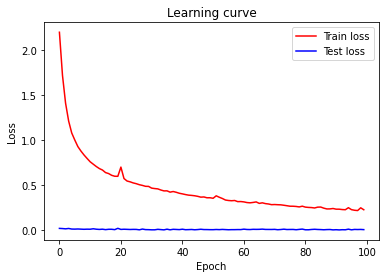

Accuracy 82 %


In [ ]:

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

optim = torch.optim.Adam(model_ft.parameters(), lr = 0.01)
loss_func = nn.CrossEntropyLoss()

trained_model_transfer_learning = train_model(model_ft,trainloader, optim, loss_func,'Transfer learning')
results['Transfer learning'] = test_model(trained_model_transfer_learning, testloader)

## Training a model with an implementation taken from the Pytorch library.

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch: 0, step: 0, loss: 7.159979343414307
epoch: 0, step: 100, loss: 2.04848575592041
epoch: 0, step: 200, loss: 1.831690788269043
epoch: 0, step: 300, loss: 1.5547460317611694
test loss: tensor(0.0162, device='cuda:0')
epoch: 1, step: 0, loss: 1.5623482465744019
epoch: 1, step: 100, loss: 1.3507757186889648
epoch: 1, step: 200, loss: 1.3832101821899414
epoch: 1, step: 300, loss: 1.405722975730896
test loss: tensor(0.0210, device='cuda:0')
epoch: 2, step: 0, loss: 1.180977702140808
epoch: 2, step: 100, loss: 1.197967767715454
epoch: 2, step: 200, loss: 1.206693172454834
epoch: 2, step: 300, loss: 1.254131555557251
test loss: tensor(0.0118, device='cuda:0')
epoch: 3, step: 0, loss: 1.045340895652771
epoch: 3, step: 100, loss: 1.138580083847046
epoch: 3, step: 200, loss: 1.1125030517578125
epoch: 3, step: 300, loss: 0.9116226434707642
test loss: tensor(0.0090, device='cuda:0')
epoch: 4, step: 0, loss: 0.9042101502418518
epoch: 4, step: 100, loss: 1.076470971107483
epoch: 4, step: 200, l

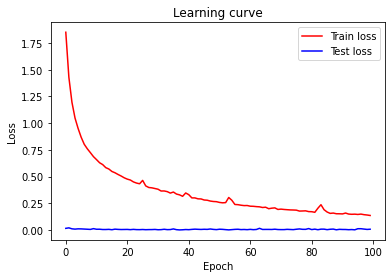

Accuracy 83 %


In [ ]:
model_ = models.resnet18(pretrained=False)

optim = torch.optim.Adam(model_.parameters(), lr = 0.01)
loss_func = nn.CrossEntropyLoss()

trained_model_from_pytoch = train_model(model_,trainloader, optim, loss_func, 'Pytorch realization')
results['Pytorch realization']  = test_model(trained_model_from_pytoch, testloader)

## Analysing the results


In [ ]:
results

,Own realization,Transfer learning,Pytorch realization
accuracy,90.63,82.45,83.56


<b>Note:</b>


Three options for implementing the ResNet18 architecture are considered:

<ul>
<li>Own implementation</li>
<li>Transfer learning approach</li>
<li>Pytroch implementation</li>
</ul>

It is worth noting that a model that is implemented independently takes 100 epochs to reach the target accuracy. This is not enough for other implementations of the ResNet18 architecture; more epochs are needed to train them.

If you rely on the accuracy metric - accuracy, then the most accurate model, a model with its own implementation.

